Juypter notebook focusing on the investigation and use of the MS COCO dataset. This was created for CSU's CS445

The goal of this model is to recognize and select cats, dogs, cows, horses, and birds out of a photo

With that in mind we will be developing it specifically for instance segmentation

Contributers: Tucker Laurence, Yasas Wijesekara

In [40]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
import urllib
from pycocotools.coco import COCO
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from collections import Counter
import random
from torch.utils.data import DataLoader
from torchvision import transforms


Global variables used to select conditions about the dataset


In [41]:
annotation_dir='./../annotations'
val_data_name='val2017'
train_data_name='train2017'

val_image_dir = './../datasets/val'
train_image_dir = './../datasets/train'

# relevant_categories = ['cat', 'dog', 'cow', 'horse', 'bird']
relevant_categories = ['dog']

This section focuses on the importing and loading of the dataset VIA pycotools.coco, which is the official access tools for MS COCO

In [42]:
class CocoSegmentationDataset(Dataset):
    """
    PyTorch Dataset for COCO-style instance segmentation tasks.
    if attribute normalize is set to True then any index retrieved sample is normalized

     Args:
        img_dir (str): Path to directory containing images.
        annotation_directory (str): Path to directory with COCO annotation JSON file.
        data_name (str): Name suffix for COCO annotation file.
        relevant_categories (List[str]): List of category names to include.
        transforms (callable, optional): Transformation function to apply to images and targets.
        """
    
    def __init__(self, img_dir, annotation_directory, data_name, relevant_categories, transforms=None):
        # Initialize COCO API and get data during instantiation
        annFile = '{}/instances_{}.json'.format(annotation_directory, data_name)
        self.coco = COCO(annFile)
        self.verbose = True
        
        self.img_dir = img_dir
        self.relevant_categories = relevant_categories
        
        category_ids, image_ids = self._instantiate_ids()

        self.image_ids = image_ids
        self.category_ids = category_ids
        self.transforms = transforms
        
        # Map category_ids to new 1-X labels dynamically
        self.category_to_class_dict = {cat_id: idx+1 for idx, cat_id in enumerate(self.category_ids)}
        self.class_to_category_dict = {v: k for k, v in self.category_to_class_dict.items()}
        
        self.normalize = False
        self.normal_image_size = (224,224)
        
        self.image_ids = self._filter_valid_images()

    def _instantiate_ids(self):
        category_ids = self.coco.getCatIds(catNms=self.relevant_categories)
        image_ids = []
        
        for category in category_ids:
            temp_img_ids = self.coco.getImgIds(catIds=category)
            image_ids += temp_img_ids
        
        image_ids = list(set(image_ids))
        
        print(f"Found {len(image_ids)} images for {self.relevant_categories}")
        
        return category_ids, image_ids

    def __len__(self):
        """
        Returns:
            int: Number of image samples.
        """
        return len(self.image_ids)

    def __getitem__(self, index):
        """
        Loads a sample image and its corresponding target annotation.

        Args:
            index (int): Index of the sample to load.

        Returns:
            Tuple[Image.Image, Dict]: The image and a dictionary containing 'boxes', 'labels', 'masks', and 'image_id'.
        """
        if self.verbose:
            print(f"Loading item {index}")
            
        img_id = self.image_ids[index]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.img_dir, img_info['file_name'])
        image = Image.open(img_path).convert("RGB")

        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)

        masks = []
        boxes = []
        labels = []

        for ann in anns:
            mask = self.coco.annToMask(ann)
            masks.append(mask)

            x, y, w, h = ann['bbox']
            boxes.append([x, y, x + w, y + h])

            original_label = ann['category_id'] #get json label            
            labels.append(self.category_to_class_dict[original_label])  # remapped label using dictionary so that labels contains 1-x classes

        
        #This formatting might need to change
        masks = torch.as_tensor(np.array(masks), dtype=torch.uint8)
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {
            'boxes': boxes,
            'labels': labels,
            'masks': masks,
            'image_id': torch.tensor([img_id]),
        }

        if self.normalize:
            image, target = self._normalize_sample(image, target, new_size=self.normal_image_size)
            
        if self.transforms:
            image, target = self.transforms(image, target)
        else:
            image = transforms.ToTensor()(image)

        return image, target
    
    def _normalize_sample(self, image, target, new_size):
        """
        Resizes image, bounding boxes, and masks to a given size.

        Args:
            image (PIL.Image or torch.Tensor): The image to normalize.
            target (dict): Dictionary containing 'boxes' and 'masks'.
            new_size (Tuple[int, int]): Desired (width, height) for output image and masks.

        Returns:
            Tuple[PIL.Image.Image, Dict]: Resized image and updated target dictionary.
        """
        new_w, new_h = new_size

        if isinstance(image, torch.Tensor):
            old_h, old_w = image.shape[-2], image.shape[-1]
            image = F.to_pil_image(image)
        else:
            old_w, old_h = image.size

        # Resize image
        image = image.resize((new_w, new_h))

        # Scale boxes
        scale_x = new_w / old_w
        scale_y = new_h / old_h
        boxes = target['boxes']
        boxes = boxes.clone()
        boxes[:, [0, 2]] = boxes[:, [0, 2]] * scale_x
        boxes[:, [1, 3]] = boxes[:, [1, 3]] * scale_y
        target['boxes'] = boxes

        # Resize masks
        resized_masks = []
        for mask in target['masks']:
            mask_img = Image.fromarray(mask.numpy())
            resized_mask = mask_img.resize((new_w, new_h), resample=Image.NEAREST)
            resized_masks.append(np.array(resized_mask))
        target['masks'] = torch.as_tensor(np.stack(resized_masks), dtype=torch.uint8)

        return image, target
    
    def _filter_valid_images(self):
        valid_image_ids = []
        for img_id in self.image_ids:
            try:
                img_info = self.coco.loadImgs(img_id)[0]
                img_path = os.path.join(self.img_dir, img_info['file_name'])
                image = Image.open(img_path).convert("RGB")
                ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.category_ids, iscrowd=None)
                anns = self.coco.loadAnns(ann_ids)
                
                # Validate there is at least one valid annotation
                if len(anns) == 0:
                    continue

                # Check for valid masks and bounding boxes
                for ann in anns:
                    _ = self.coco.annToMask(ann)
                    _ = ann['bbox']
                
                valid_image_ids.append(img_id)

            except Exception as e:
                if self.verbose:
                    print(f"Skipping image {img_id} due to error: {e}")
                continue

        print(f"Filtered dataset down to {len(valid_image_ids)} valid images.")
        return valid_image_ids


    
    def download_images(self, verbose=False):
        """
        Downloads COCO images into the specified image directory if they are not already present.

        Args:
            verbose (bool, optional): Whether to print progress messages. Defaults to False.
        """
        current_image_count = 1
        total_image_count = len(self)

        if not os.path.exists(self.img_dir):
            os.makedirs(self.img_dir)

        for img_id in self.image_ids:
            img_info = self.coco.loadImgs(img_id)[0]
            file_name = img_info['file_name']
            url = img_info.get('coco_url')

            img_count_string = f'{current_image_count}/{total_image_count}'

            if url is None:
                print(f"No URL found for image {file_name}, skipping.")
                continue

            save_path = os.path.join(self.img_dir, file_name)
            if not os.path.exists(save_path):
                try:
                    urllib.request.urlretrieve(url, save_path)
                    if verbose: print(f"{img_count_string} Downloaded {file_name}")
                except Exception as e:
                    if verbose:  print(f"{img_count_string} Failed to download {file_name}: {e}")
            else:
                if verbose: print(f"{img_count_string} Image already exists: {file_name}")

            current_image_count += 1

        print(f'Interfaced with {current_image_count-1} unique images')

    def show_data_distribution(self):
        """
        Displays a bar chart of the number of instances per category in the dataset.
        """
        all_labels = []
        category_labels = []
        
        for index in range(len(self)):
            _, target = self.__getitem__(index)
            all_labels.extend(target['labels'].tolist())
        
        for label in all_labels:
            category_labels.append(self.class_to_category_dict[label])

        label_counts = Counter(category_labels)
        category_names = [self.coco.loadCats([cat_id])[0]['name'] for cat_id in label_counts.keys()]
        counts = list(label_counts.values())

        plt.figure(figsize=(10, 5))
        plt.bar(category_names, counts, color='skyblue')
        plt.xticks(rotation=45, ha='right')
        plt.ylabel('Number of Instances')
        plt.title('Category Distribution in Dataset')
        plt.tight_layout()
        plt.show()


This class is used to show the images in a CoCoSegmentationDataset

In [43]:
class ImageVisualizer():
    """
    A helper class to visualize images from a COCO-style segmentation dataset.
    Supports displaying plain images, images with bounding boxes, or with segmentation masks.
    """

    def _plot_image_on_ax(self, dataset: CocoSegmentationDataset, ax, index):
        """
        Plots a plain image from the dataset on the given Matplotlib axis.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images.
            ax (matplotlib.axes.Axes): Axis on which to draw the image.
            index (int): Index of the image to display.
        """
        image, _ = dataset[index]
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"ID: {dataset.image_ids[index]}", fontsize=8)

    def _plot_image_with_boxes_on_ax(self, dataset: CocoSegmentationDataset, ax, index):
        """
        Plots an image with bounding boxes and category labels on the given axis.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images and annotations.
            ax (matplotlib.axes.Axes): Axis on which to draw.
            index (int): Index of the image to display.
        """
        image, target = dataset[index]
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)

        ax.imshow(image)
        boxes = target['boxes']
        labels = target['labels']
        category_ids = [dataset.class_to_category_dict[label.item()] for label in labels]
        
        category_names = [dataset.coco.loadCats([category_id])[0]['name'] for category_id in category_ids]

        for box, label, category_name in zip(boxes, labels, category_names):
            x1, y1, x2, y2 = box
            rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1, fill=False, edgecolor='red', linewidth=2)
            ax.add_patch(rect)
            ax.text(x1, y1, category_name, color='white', fontsize=6,
                    bbox=dict(facecolor='red', edgecolor='none', pad=1))
        ax.axis('off')
        ax.set_title(f"ID: {dataset.image_ids[index]}", fontsize=8)

    def _plot_image_with_masks_on_ax(self, dataset: CocoSegmentationDataset, ax, index):
        """
        Plots an image with segmentation masks overlaid on the given axis.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images and segmentation masks.
            ax (matplotlib.axes.Axes): Axis on which to draw.
            index (int): Index of the image to display.
        """
        image, target = dataset[index]
        if isinstance(image, torch.Tensor):
            image = F.to_pil_image(image)

        ax.imshow(image)
        masks = target['masks'].numpy()
        for mask in masks:
            ax.imshow(mask, alpha=0.4)
        ax.axis('off')
        ax.set_title(f"ID: {dataset.image_ids[index]}", fontsize=8)
    
    def show_images(self, dataset: CocoSegmentationDataset, indices, mode='plain'):
        """
        Displays multiple images from the dataset in a row using the specified visualization mode.

        Args:
            dataset (CocoSegmentationDataset): Dataset containing images and annotations.
            indices (int or list of int): Index/indices of the images to display.
            mode (str): Visualization mode. One of 'plain', 'boxes', or 'masks'.
        """
        if type(indices) == int:
            indices = [indices]
            
        cols = len(indices)
        fig, axs = plt.subplots(1, cols, figsize=(cols * 4, 4))
        
        if cols == 1:
            axs = [axs]

        for ax, idx in zip(axs, indices):
            if mode == 'plain':
                self._plot_image_on_ax(dataset, ax, idx)
            elif mode == 'boxes':
                self._plot_image_with_boxes_on_ax(dataset, ax, idx)
            elif mode == 'masks':
                self._plot_image_with_masks_on_ax(dataset, ax, idx)
            else:
                raise ValueError(f"Unknown mode: {mode}")

        plt.tight_layout()
        plt.show()


In [44]:
#Instantiate the visualizer
visualizer = ImageVisualizer()

In [45]:
# train_dataset = CocoSegmentationDataset(train_image_dir, annotation_dir, train_data_name, relevant_categories)
val_dataset = CocoSegmentationDataset(val_image_dir, annotation_dir, val_data_name, relevant_categories)

loading annotations into memory...
Done (t=0.40s)
creating index...
index created!
Found 177 images for ['dog']
Skipping image 72813 due to error: image file is truncated (10 bytes not processed)
Filtered dataset down to 176 valid images.


In [46]:
# train_dataset.download_images(verbose=True)
val_dataset.download_images(verbose=False)

Interfaced with 176 unique images


Loading item 96


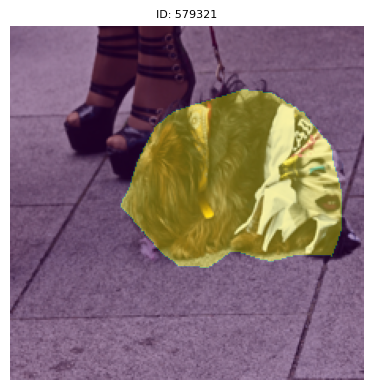

In [47]:
r_idx = random.randrange(len(val_dataset) - 1)
val_dataset.normalize = True
# visualizer.show_images(val_dataset, r_idx)
# visualizer.show_images(val_dataset, r_idx, mode='boxes')
visualizer.show_images(val_dataset, r_idx, mode='masks')

# val_dataset.normalize = True
# visualizer.show_images(val_dataset, r_idx)
# visualizer.show_images(val_dataset, r_idx, mode='boxes')
# visualizer.show_images(val_dataset, r_idx, mode='masks')
# val_dataset.normalize = False

In [48]:
image, target = val_dataset[r_idx]

print(f"Image shape: {image.shape}")                 # should be [3, H, W]
print(f"Boxes: {target['boxes'].shape}")             # should be [N, 4]
print(f"Labels: {target['labels']}")                 # tensor of ints
print(f"Masks shape: {target['masks'].shape}")       # [N, H, W]
print(f"Image ID: {target['image_id']}")             # tensor([img_id])
print(f"Mask Values {torch.unique(target['masks'])}")
print(target['masks'].dtype)

Loading item 96
Image shape: torch.Size([3, 224, 224])
Boxes: torch.Size([1, 4])
Labels: tensor([1])
Masks shape: torch.Size([1, 224, 224])
Image ID: tensor([579321])
Mask Values tensor([0, 1], dtype=torch.uint8)
torch.uint8


In [49]:
# val_dataset.show_data_distribution()

Next steps required for data

(Potential, but difficult)
Data augmentation: flipping, rotation, color jitter, pixel normalization, etc

Datasets needs for pre trained models

MODEL 1 Custom Preprocessing and training/test/val

In [50]:
def custom_collate(batch):
    return tuple(zip(*batch))

In [51]:
val_dataset.verbose = False
val_dataset.normalize = True

train_loader = DataLoader(val_dataset, 
            batch_size=8, 
            shuffle=True,
            num_workers=0, 
            collate_fn=custom_collate
            )

In [ ]:
# from torchvision.models.detection import maskrcnn_resnet50_fpn
# from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
# import torch

# # Model setup
# def get_instance_segmentation_model(num_classes):
#     # Load a model pre-trained on COCO
#     model = maskrcnn_resnet50_fpn(pretrained=True)

#     # Replace the box predictor
#     in_features = model.roi_heads.box_predictor.cls_score.in_features
#     model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

#     # Replace the mask predictor
#     in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
#     hidden_layer = 256
#     model.roi_heads.mask_predictor = MaskRCNNPredictor(
#         in_features_mask, hidden_layer, num_classes
#     )

#     return model

# num_classes = len(relevant_categories) + 1  # +1 for background
# model = get_instance_segmentation_model(num_classes)

# # Training setup
# device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# model.to(device)

# # Construct optimizer
# params = [p for p in model.parameters() if p.requires_grad]
# optimizer = torch.optim.SGD(params, lr=0.005,
#                             momentum=0.9, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# # Training loop
# from tqdm import tqdm
# num_epochs = 10

# print("Starting Training")
# for epoch in range(num_epochs):
#     model.train()
#     running_loss = 0.0
#     for images, targets in tqdm(train_loader):
#         images = list(img.to(device) for img in images)
#         targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

#         loss_dict = model(images, targets)
#         losses = sum(loss for loss in loss_dict.values())

#         optimizer.zero_grad()
#         losses.backward()
#         optimizer.step()

#         running_loss += losses.item()

#     lr_scheduler.step()
#     torch.save(model.state_dict(), f"model_epoch_{epoch+1}.pth")
#     print(f"Epoch {epoch+1}, Loss: {running_loss:.4f}")

Starting Training


  0%|          | 0/22 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# torch.save({
#     'epoch': epoch,
#     'model_state': model.state_dict(),
#     'optimizer_state': optimizer.state_dict(),
#     'scheduler_state': lr_scheduler.state_dict()
# }, 'checkpoint.pth')